# Fault modeling example
Made for ESCAPE program - 2024



In [1]:
# import statements - general statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize

# import statements - specific to our problem.
import fault_model
import fault_plots

# this special Jupyter command makes zooming, panning and downloading the figures easy
#%matplotlib widget

# import statement for an interactive plot
from ipywidgets import interactive

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

### Setting up a model

To create a model of surface displacement caused by slip on a fault, we use a fairly complicated analytic solution - check out the file "okada85.py" to see the details.


![okada fault model](https://www.researchgate.net/publication/229912692/figure/fig5/AS:271201062879250@1441670780804/Geometry-of-the-dislocation-source-model-modified-from-Okada-1985-The-model-is.png)


Because this is a complicated system, we'll hide the details inside "fault_model.py". To use that module, we run it as follows:

In [2]:
# define a function that implements the fault modeling functions defined in fault_model.py.
def create_fault_model(gpslon,gpslat,latcorner,loncorner,depthcorner,strike,dip,L,W,ss,ds):
    Fmod=fault_model.FaultModel()
    Fmod.create_planar_model(latcorner=latcorner,loncorner=loncorner,depthcorner=depthcorner,strike=strike,dip=dip,L=L,W=W,nL=1,nW=1)

    # get the "G" matrix for our particular GPS site locations (lat,lon) - note this is Y,X in our notation, which can be confusing.
    G=Fmod.get_greens(gpslat,gpslon)
    
    # m is the slip
    m=np.array([ss,ds])
    
    # predict GPS displacements with d=G*m
    gpsmotion = np.matmul(G,m)
    predicted_E = gpsmotion[0::3] # this notation means start from first element (0), then take every 3rd one
    predicted_N = gpsmotion[1::3]
    predicted_U = gpsmotion[2::3]
    
    return predicted_E,predicted_N,predicted_U,Fmod


# let's create a grid of data and play around with a fault model:

# units of latitude and longitude are in degrees. I'll create a "pretend" area around a point in the Mojave desert... you'll see why soon!
Npts=30
lon=np.linspace(-119,-116,Npts)
lat=np.linspace(34.5,37.5,Npts)

# create a "mesh grid" of locations
Lon,Lat = np.meshgrid(lon,lat)
Lon=np.reshape(Lon,Npts*Npts)
Lat=np.reshape(Lat,Npts*Npts)

# define a function for all the plotting and mapping commands, including running the fault model and comparing to data

# Note, the equals signs in the function definition set up a default value for each parameter
def plot_test_model(latcorner=35.5,loncorner=-117.3,depthcorner=0,strike=-35,dip=85,L=100e3,W=20e3,ss=-100,ds=0):
    # create a fault model
    # note, we pass gpslon and gpslat here, but it is not an input to this function. 
    # we are assuming it is already a global variable...
    predicted_E,predicted_N,predicted_U,Fmod = create_fault_model(Lon[:],Lat[:],latcorner,loncorner,depthcorner,strike,dip,L,W,ss,ds)

    # plot the fault model and GPS
    Fplot = fault_plots.FaultPlot2D(figsize=(10,6.5))
    
    # get the axes object so we can do normal things to it
    ax = Fplot.get_ax()
    ax.set_xlim([-119, -116])
    ax.set_ylim([35, 37])
    ax.grid()

    up = plt.scatter(Lon, Lat,s=210,c=predicted_U,cmap='RdBu_r',marker='s')
    plt.colorbar(up)
    plt.clim([-10,10])
    Fplot.plot_slip_outlines(Fmodel=Fmod)
    #Fplot.plot_slip_patches(Fmodel=Fmod,slip=[ss],colorbar=False)

    q=ax.quiver(Lon,Lat,predicted_E,predicted_N, scale=400,color='black')
    ax.quiverkey(q,X=0.93,Y=0.95,U=20, label ='20 cm') # make quiver legend
    
w = interactive(plot_test_model,latcorner=(35,37,.01),loncorner=(-118,-116.5,.01),depthcorner=(0,30e3),strike=(-180,180),dip=(0,180),L=(0,200e3),W=(0,200e3),ss=(-300,300),ds=(-100,100))
display(w)

interactive(children=(FloatSlider(value=35.5, description='latcorner', max=37.0, min=35.0, step=0.01), FloatSl…

### Fitting real data

That was great fun! Now let's try fitting some real GPS data:

This dataset contains the GPS displacements for the 100 stations nearest to the 2019 Ridgecrest, CA earthquake.

In [11]:
# load GPS data
gpsdata = pd.read_csv('GPS_Ridgecrest.csv')

# I will convert them all to arrays at the start.
gpslon = np.asarray(gpsdata["X"])
gpslat = np.asarray(gpsdata["Y"])
gps_dE = np.asarray(gpsdata["E"])/100 # units of displacement in the file are cm, so convert them to meters
gps_dN = np.asarray(gpsdata["N"])/100 # convert to meters


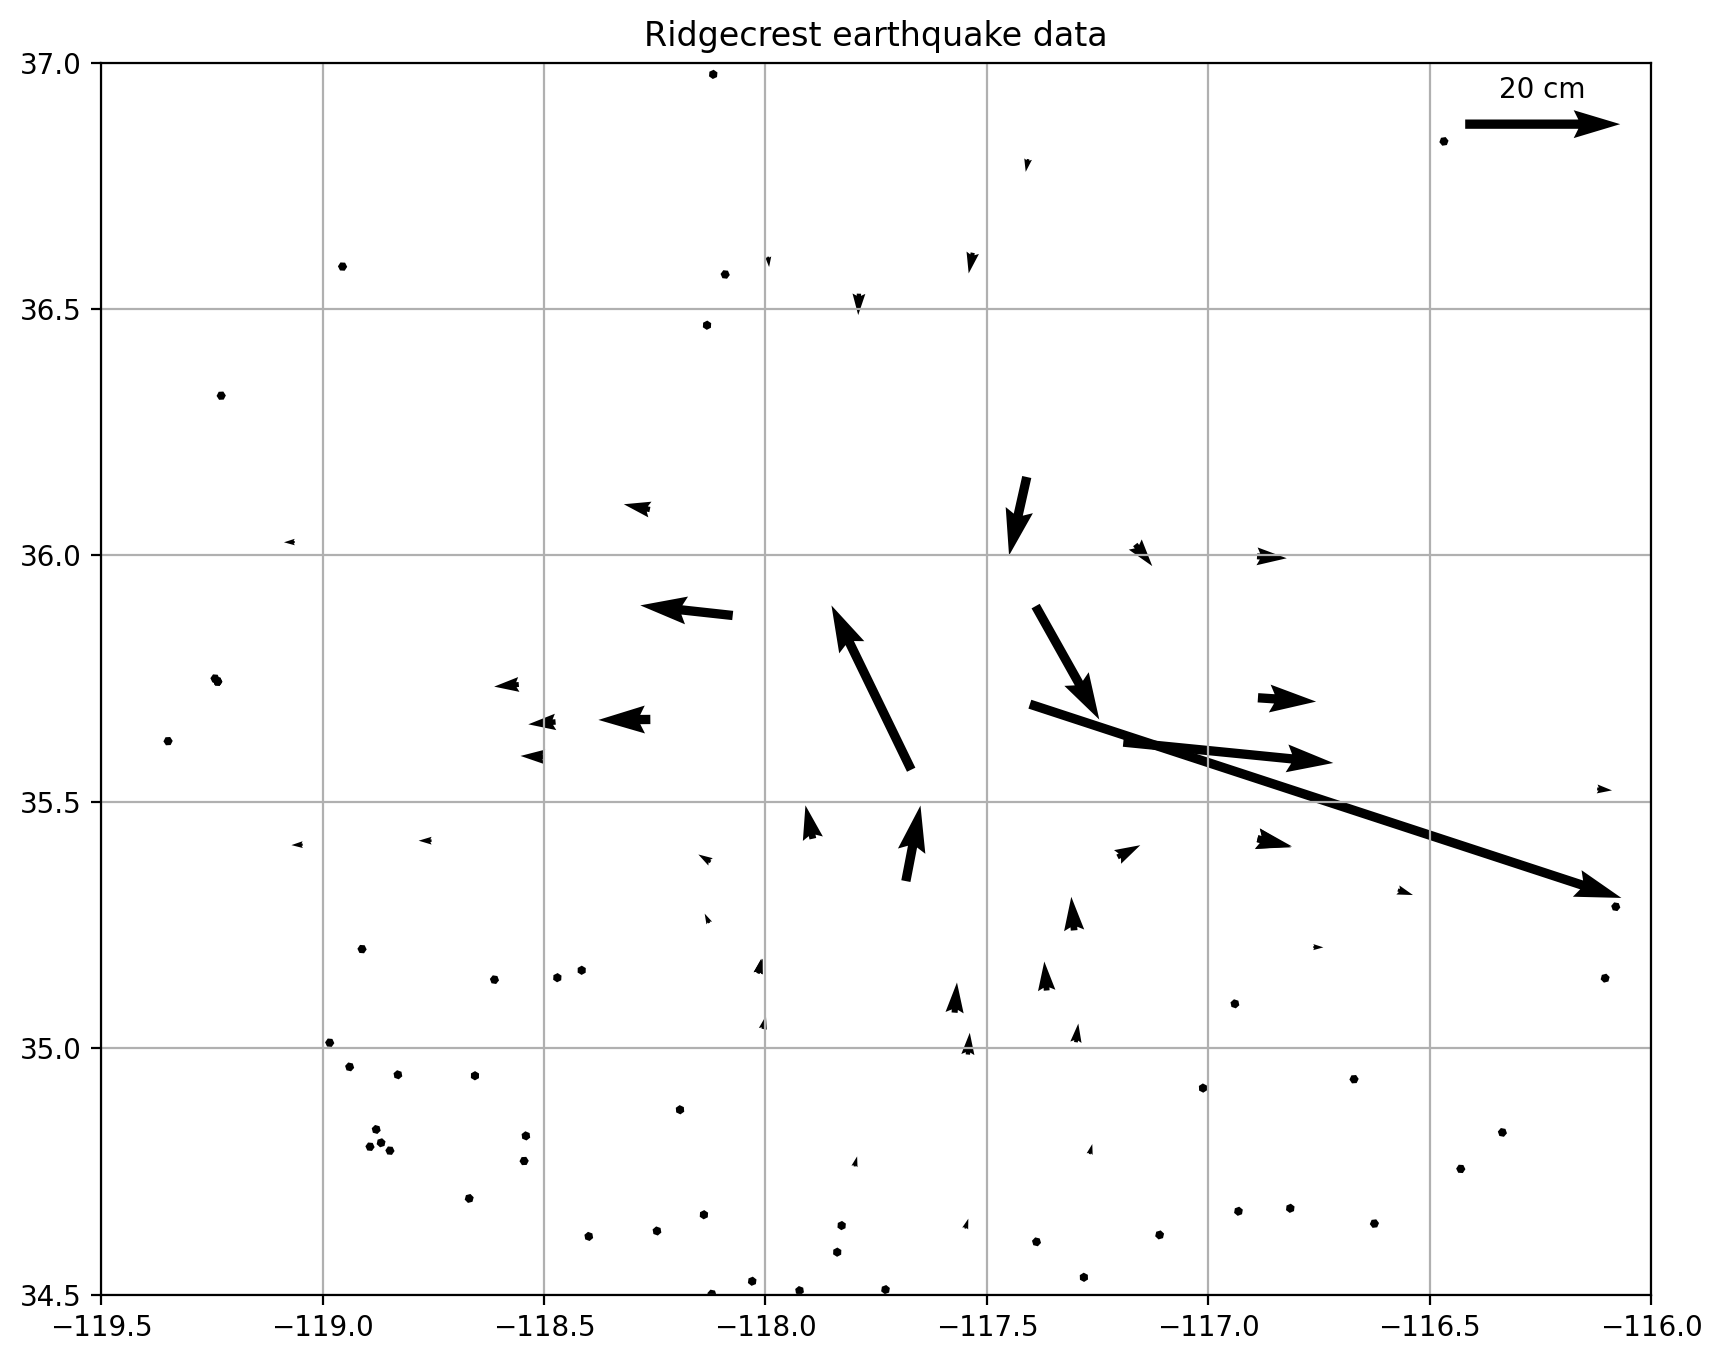

In [13]:
# create a map to view the GPS data

# sorry, this dataset did not include the vertical motions, only horizontal

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1, 1, 1,)
ax.set_xlim([-119.5, -116])
ax.set_ylim([34.5, 37])
ax.grid() # Add gridlines and labels

# Plot vectors
vecscale = 2 # note, larger scale means smaller arrows
q = ax.quiver(gpslon,gpslat,gps_dE,gps_dN, scale=vecscale)
plt.quiverkey(q,X=0.93,Y=0.95,U=0.2, label ='20 cm') # make quiver legend

plt.title('Ridgecrest earthquake data')
plt.show()

In [31]:

# define a function for all the plotting and mapping commands, including running the fault model and comparing to data

# Note, the equals signs in the function definition set up a default value for each parameter
def plot_fault_and_gps(latcorner=35.5,loncorner=-117.3,depthcorner=0,strike=-35,dip=85,L=100e3,W=10e3,ss=-1,ds=0):
    # create a fault model
    # note, we pass gpslon and gpslat here, but it is not an input to this function. 
    # we are assuming it is already a global variable...
    predicted_E,predicted_N,predicted_U,Fmod = create_fault_model(gpslon,gpslat,latcorner,loncorner,depthcorner,strike,dip,L,W,ss,ds)

    # compute the reduced chi squared statistic: sum of the residuals, divided by the squared uncertainty and the number of data points minus one
    gps_uncertainty = 0.005 # let's assume an uncertainty of 5mm
    misfit=np.sum((predicted_E-gps_dE)**2+(predicted_N-gps_dN)**2)/(gps_uncertainty**2*(2*len(gps_dN)-1))

    # compute the earthquake magnitude
    magnitude = (2/3)*np.log10(1e7*30e9*L*W*(ss**2+ds**2)**0.5) - 10.7
    
    # plot the fault model and GPS
    Fplot = fault_plots.FaultPlot2D(figsize=(10,7))
    Fplot.plot_slip_outlines(Fmodel=Fmod)

    # get the axes object so we can do normal things to it
    ax = Fplot.get_ax()
    ax.set_xlim([-119.5, -116])
    ax.set_ylim([34.5, 37])
    ax.set_title('Reduced $\chi^2$: %.3f, Magnitude: %.2f' %(misfit,magnitude))
    ax.grid()

    # commands for quiver are the same
    vecscale=2
    q = ax.quiver(gpslon,gpslat,gps_dE,gps_dN, scale=vecscale,color='blue')
    q2= ax.quiver(gpslon,gpslat,predicted_E,predicted_N, scale=vecscale,color='orange')
    ax.quiverkey(q,X=0.93,Y=0.95,U=0.2, label ='Data: 20 cm') # make quiver legend
    ax.quiverkey(q2,X=0.93,Y=0.85,U=0.2, label ='model') # make quiver legend

# why did we put all the plotting commands inside an annoying function? Because now we can make it interactive!
w = interactive(plot_fault_and_gps,latcorner=(35,37,.01),loncorner=(-118,-116.5,.01),depthcorner=(0,30e3),strike=(-180,180),dip=(0,180),L=(0,200e3),W=(0,20e3),ss=(-4.0,4.0),ds=(-2.0,2.0))
display(w)

interactive(children=(FloatSlider(value=35.5, description='latcorner', max=37.0, min=35.0, step=0.01), FloatSl…

In [27]:
# let's use scipy.optimize.curve_fit to fit the GPS data.
# to use this, we need a function that takes as input the independent variables (station locations) as a single vector, and model parameters (fault),
# and outputs the dependent variables (gps displacements) as a single vector.

# note there is a numerical instability for this case. We fix the fault width to make things work better. Try changing it and see what happens!
fix_width = 10000 # 10km default

def fault_model_for_fitting(gps_locs,latcorner,loncorner,depthcorner,strike,dip,L,ss,ds):
    # for the modeling, we need the locations as x and y, not a single vector
    Ngps=int(np.size(gps_locs)/2)
    gpslat=gps_locs[:Ngps]
    gpslat=gps_locs[Ngps:]
    
    # create the model
    Fmod=fault_model.FaultModel()
    Fmod.create_planar_model(latcorner=latcorner,loncorner=loncorner,depthcorner=depthcorner,strike=strike,dip=dip,L=L,W=fix_width,nL=1,nW=1)
    
    # get the "G" matrix for our particular GPS site locations (lat,lon) - note this is Y,X in our notation, which can be confusing.
    G=Fmod.get_greens(gpslat,gpslon)
    
    # m is the slip
    m=np.array([ss,ds])
    
    # predict GPS displacements with d=G*m
    gpsmotion = np.matmul(G,m)
    predicted_E = gpsmotion[0::3] # this notation means start from first element (0), then take every 3rd one
    predicted_N = gpsmotion[1::3]
    
    # get the displacements as a single vector
    predicted_displacements=np.append(predicted_E,predicted_N)
    
    # return the predicted values
    return predicted_displacements

# create single vectors for the locations and displacements
gps_locations=np.append(gpslon,gpslat)
gps_displacements=np.append(gps_dE,gps_dN)

m,mcov = scipy.optimize.curve_fit(fault_model_for_fitting,gps_locations,gps_displacements,p0=[35.5,-117.3,0,-35,85,100e3,-1,0],maxfev=10000)
print(m)


[ 3.55875767e+01 -1.17405853e+02 -1.05186634e+03 -3.85425693e+01
  1.02169522e+02  3.46103661e+04 -3.56383166e+00  1.34267069e+00]


Best fitting solution: lat 35.587577, lon -117.405853, depth -1051.866337, strike -38.542569, dip 102.169522, length 34610.366101, ss -3.563832, ds 1.342671


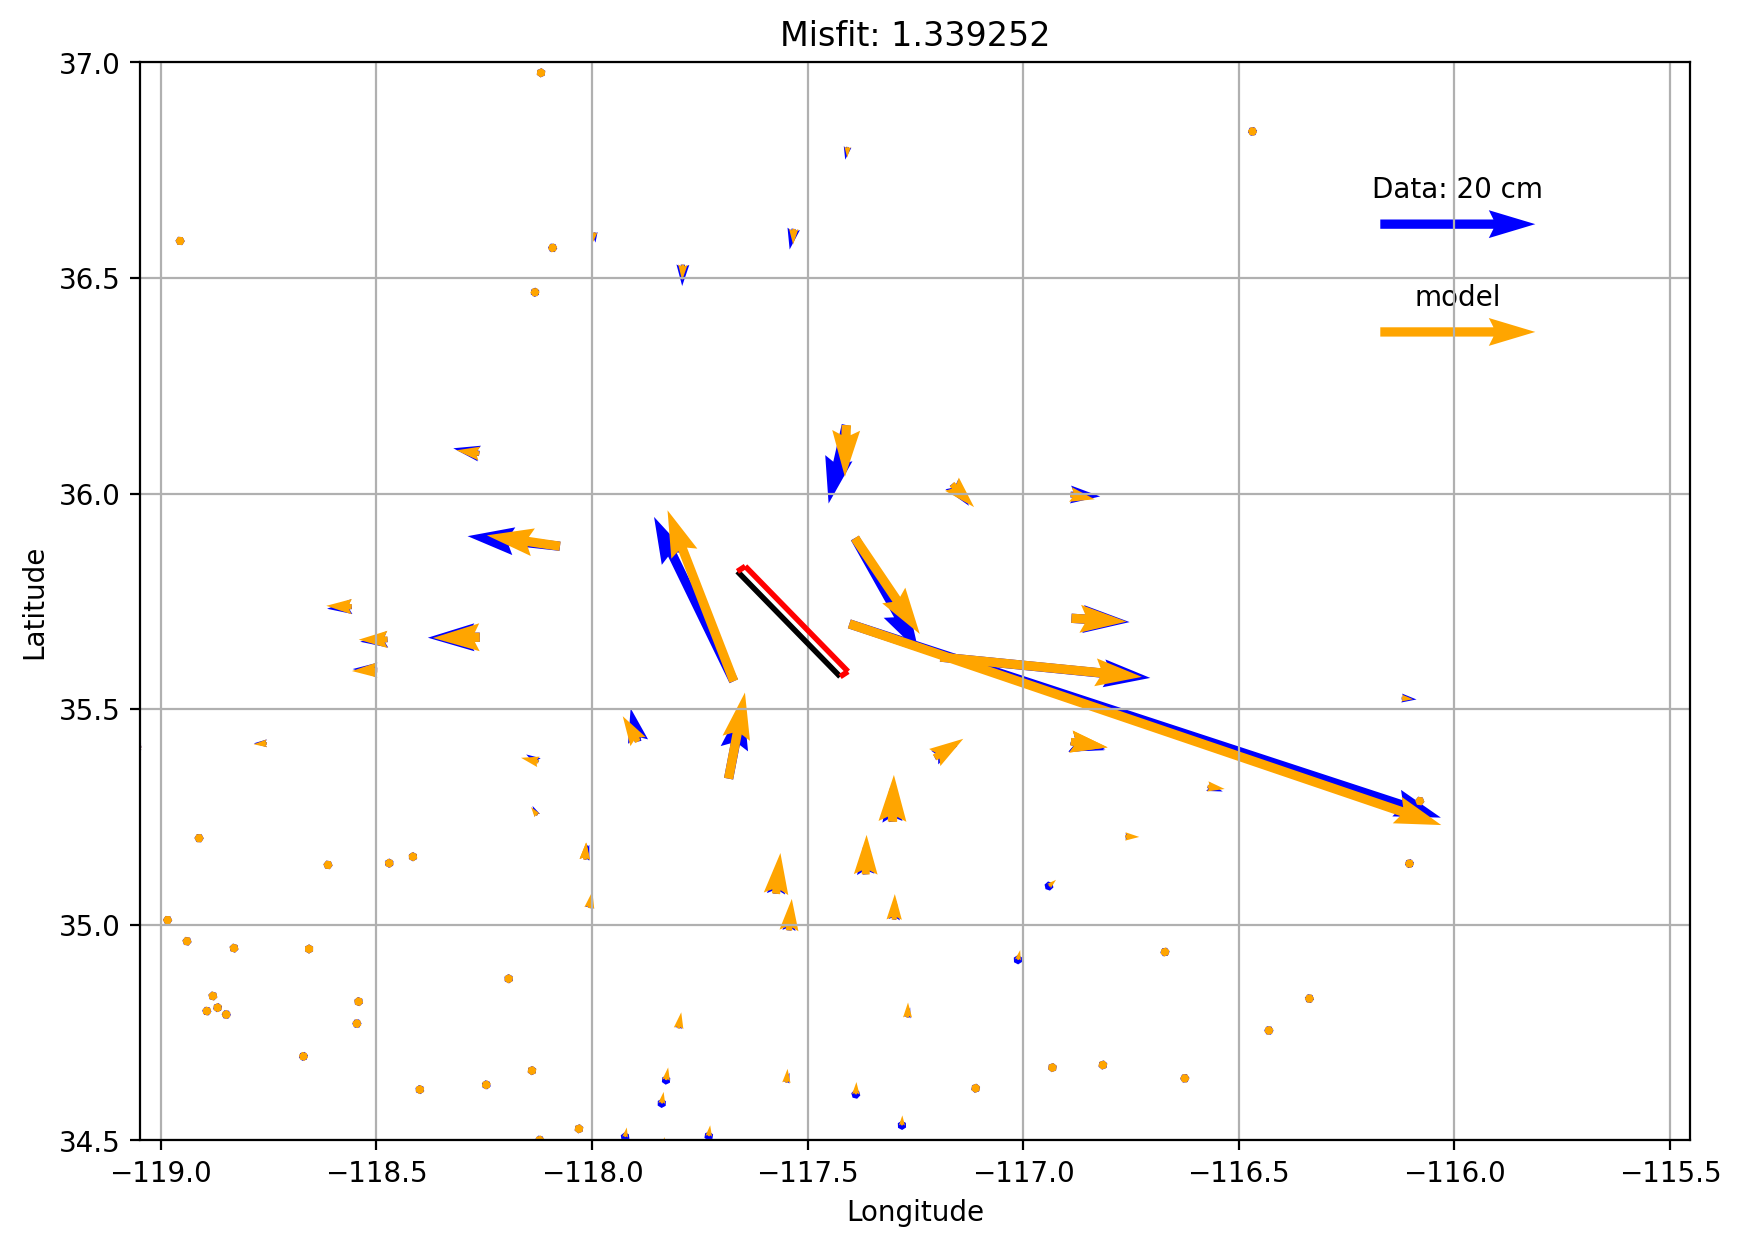

In [35]:

# get the predicted GPS displacements, by running the fault model again with the best fitting parameters (m)
gps_predicted=fault_model_for_fitting(gps_locations,m[0],m[1],m[2],m[3],m[4],m[5],m[6],m[7]) 

#split the displacements back into E and N
Ngps=int(np.size(gps_predicted)/2)
predicted_E=gps_predicted[:Ngps]
predicted_N=gps_predicted[Ngps:]

# compute the misfit: sum of the residuals
gps_uncertainty = 0.005 # let's assume an uncertainty of 5mm
misfit=np.sum((predicted_E-gps_dE)**2+(predicted_N-gps_dN)**2)/(gps_uncertainty**2*(2*len(gps_dN)-1))

# create a plot with results
# fig = plt.figure(figsize = (7,7))
# ax = fig.add_subplot(1, 1, 1)

# create the best fitting model for plotting
Fmod=fault_model.FaultModel()
Fmod.create_planar_model(m[0],m[1],m[2],m[3],m[4],m[5],fix_width,nL=1,nW=1)

# plot the fault model and GPS
Fplot = fault_plots.FaultPlot2D(figsize=(10,7))
Fplot.plot_slip_outlines(Fmodel=Fmod)

# get the axes object so we can do normal things to it
ax = Fplot.get_ax()

# note that for a non-geographic plot, we use set_xlim and set_ylim instead of set_extent.
ax.set_xlim([-119, -115.5])
ax.set_ylim([34.5, 37])
ax.grid() # grid instead of gridlines


# commands for quiver are the same
vecscale=2
q = ax.quiver(gpslon,gpslat,gps_dE,gps_dN, scale=vecscale,color='blue')
q2 = ax.quiver(gpslon,gpslat,predicted_E,predicted_N, scale=vecscale,color='orange')
ax.quiverkey(q,X=0.85,Y=0.85,U=.2, label ='Data: 20 cm') # make quiver legend
ax.quiverkey(q2,X=0.85,Y=0.75,U=.2, label ='model') # make quiver legend
plt.title('Misfit: %f' %misfit)
print('Best fitting solution: lat %f, lon %f, depth %f, strike %f, dip %f, length %f, ss %f, ds %f' %(m[0],m[1],m[2],m[3],m[4],m[5],m[6],m[7]))


In [34]:
# what is the magnitude?
length = m[5]
width = fix_width
slip = np.sqrt(m[6]**2+m[7]**2) # units must be in meters, not cm

def get_magnitude(L,W,slip):
    return (2/3)*np.log10(1e7*30e9*L*W*slip) - 10.7

mag = get_magnitude(length,fix_width,slip)
print('Earthquake magnitude: %.2f' %mag)

Earthquake magnitude: 7.03
